In [8]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

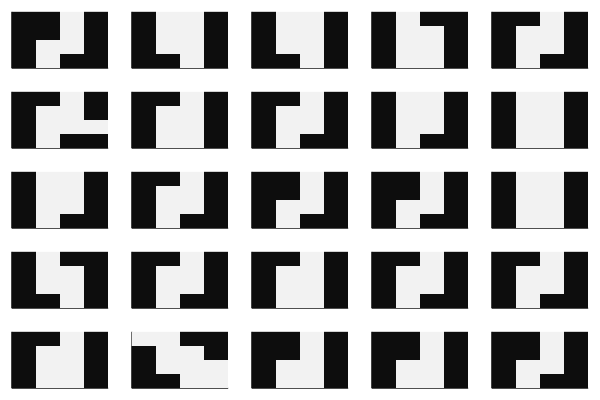

In [3]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 25 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 4 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? use pythoncall and matplotlib i guess

In [4]:
using Yao
using Flux

N = compress_size^2 #Number of qubits

function NeuralNetwork(num_dim = N, random = true)
    net = Chain(Dense(num_dim, 25, relu), Dense(25, 1, identity))
    if !random
        for p in Flux.params(net)
            p .= (ones(size(p)) .* 0.08)
        end
    end
    return net
end

#d = NeuralNetwork() #Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) #I have no clue what this looks like, and why does it have more parameters than expected (bias?)

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N) #Making the generator, which is a matchgate ansatz (IS IT???) yes because it's made up of nn XX gates and single-qubit Z gates
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

# function build_circuit(n::Int = N, nlayers::Int = layers)
#     circuit = chain(n) #Making the generator, which is a matchgate ansatz; this just uses Yao though? or does saying "using FLOYao" somehow change the implementation... Not really sure
#     for _ in 1:nlayers
#         for i in 1:N-1
#             push!(circuit, rot(kron(N, i => X, i+1 => X), 0.))
#         end
#         for i in 1:N
#             push!(circuit, put(N, i => Rz(0.)))
#         end
#     end
# end

#g = build_circuit()
#g = build_circuit() |> autodiff(:QC)

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, ones(nparams) ./ 100); 
dispatch!(g, :random);

Number of parameters in discriminator: 181


Number of parameters in generator: 155


μ: 6.48
σ: 1.004987562112089


Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

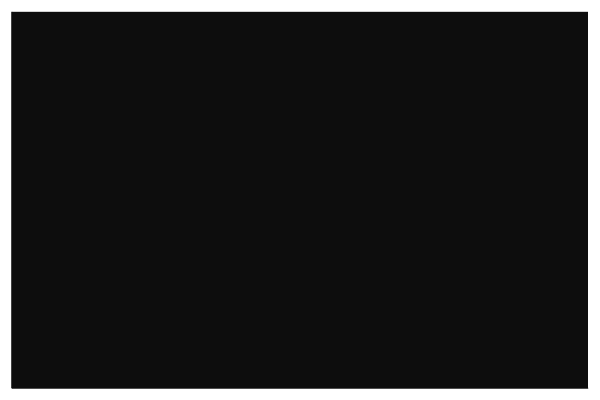

In [5]:
using FLOYao
using Random
using Distributions

#Not sure if there is a better pprior that we can choose, sometimes u get a lot of white or black bc variance is high (resolution: change var from sigma to sigma/10)
mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [6]:
using Flux: train!
using Yao
using FLOYao

batch_size = train #Are you supposed to randomly pick batch_size data points at random each time if train is big? idk
#This is the 

#g takes as input x = Int.(pprior()); FLOYao.product_state(x)
#d takes as input measure(x |> g)

function convertgd(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

function run_circuit(z::MajoranaReg) #z is a MajoranaReg drawn from pprior (to guarantee matchgate speedup); this function applies D(G(z))
    g_output = z |> g |> measure
    d_input = convertgd(g_output)
    d_output = d_input |> d
    d_output |> first
end

t = time()
measurement = run_circuit(pprior())
println("runcircuit: $measurement")
println(time() - t)

function run_d(x::BitMatrix) #this function applies D(x), where x is an element of data_train 
    d_output = x |> vec |> d
    d_output |> first
end

function gLoss(z::MajoranaReg) #z is sampled from pprior(); gLoss is technically a function of params(g) but this is implicitly implemented in run_circuit
    -log(run_circuit(z))
    #log(1 - run_circuit(z))
end

#This is the BCE loss?
function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end


# function dLoss(m, real, fake) #BCE loss

# end

# function dLoss(m, fake)
#     -(log.(m(real)) + log.(1 .- m(fake))) |> first
# end

z = pprior()
print(gLoss(z))

runcircuit: 0.5074217
1.6131558418273926
0.67443746

In [10]:
using Yao
using FLOYao

# Worry about this another day
# function gradient(op, reg::MajoranaReg) #does expect' (from FLOYao? or does it come from Yao?) use AD? Also idk what op should be
#     _, params_grad = expect'(op, reg => g)
# end

samplemean_batchsize = 100 #What is a good samplemean_batchsize? maybe just pick one that doesn't take a super long time 

function parametershift_grad(b = samplemean_batchsize)
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    for i in 1:nparameters(g)
        plus = 0
        minus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + π/2
        dispatch!(g, temp_params)
        for _ in 1:b
            z = pprior()
            plus += gLoss(z)
        end
        plus /= b
        temp_params[i] = temp - π/2
        dispatch!(g, temp_params)
        for _ in 1:b
            z = pprior()
            minus += gLoss(z)
        end
        minus /= b
        grad[i] = (minus - plus) / 2
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

#parametershift_grad is O((samplemean_batchsize) * (nparameters))
#In computing sample means, I used different samples from pprior(); might program something later in which we use the same samples z in estimating both sample means...

for _ in 1:10
    println(parametershift_grad()) #Should print similar numbers...
end

[0.0346587598323822, 0.04065677523612976, 0.010442107915878296, -0.00841793417930603, 0.014514178037643433, -0.02304762601852417, -0.025099992752075195, 0.022524237632751465, -0.02453473210334778, -0.003732621669769287, 0.007777601480484009, -0.02098912000656128, 0.002695143222808838, 0.000699162483215332, 0.012680798768997192, 0.004187226295471191, -0.011551469564437866, -0.007672131061553955, 0.004446744918823242, -0.012544065713882446, -0.018156379461288452, -0.01772695779800415, -0.012790292501449585, -0.011772125959396362, 0.0022940635681152344, -0.0018436908721923828, -0.0010863840579986572, -0.007910996675491333, -0.008749276399612427, -0.012862145900726318, 0.004067450761795044, 0.02056083083152771, 0.044619977474212646, 0.025373607873916626, -0.020224392414093018, 0.0025306642055511475, -0.0159015953540802, 0.0007694661617279053, 0.0029076039791107178, 0.01818975806236267, 0.019553720951080322, 0.01582413911819458, -0.011362701654434204, -0.0101889967918396, 0.0044727325439453

[0.04608714580535889, 0.01903057098388672, -0.015648365020751953, 0.021555185317993164, 0.009796738624572754, -0.008793830871582031, -0.030892133712768555, 0.009488821029663086, -0.023130834102630615, 0.005352824926376343, -0.01883891224861145, -0.011738359928131104, -0.01563987135887146, 0.0032902956008911133, -0.007491737604141235, -0.01447322964668274, 0.005680352449417114, -0.015724897384643555, 0.017707794904708862, -0.015493571758270264, -0.009151071310043335, -0.0041603147983551025, 0.013510435819625854, -0.01221439242362976, 0.007392913103103638, -0.012110471725463867, 0.010647177696228027, -0.0008210241794586182, -0.012389183044433594, -0.015581101179122925, -0.017286360263824463, 0.01958039402961731, 0.04212126135826111, 0.004542917013168335, -0.012601703405380249, 0.01370963454246521, 0.008477598428726196, 0.0024890005588531494, -0.0006150305271148682, -0.024428099393844604, -0.0029456615447998047, 0.009237527847290039, -0.012524306774139404, 0.0051413774490356445, 0.0060812

[0.041034162044525146, 0.04750239849090576, -0.009824872016906738, -0.004527479410171509, 0.0023751556873321533, -0.0024392008781433105, -0.02076435089111328, 0.016537487506866455, -0.0239260196685791, 0.0012614130973815918, 0.0030911266803741455, -0.030709803104400635, 0.00290834903717041, 0.005500882863998413, 0.023245811462402344, -0.025359362363815308, -0.011762261390686035, -0.01073002815246582, 0.003050506114959717, 0.0036597251892089844, -0.005716979503631592, -0.007573127746582031, 0.022289574146270752, 0.00254744291305542, -0.011232227087020874, 0.0002620816230773926, 0.009175747632980347, -0.005965173244476318, -0.008174747228622437, -0.023299217224121094, -0.003846794366836548, 0.011906981468200684, 0.020796656608581543, 0.004925072193145752, -0.020070761442184448, 0.01582607626914978, -0.005195349454879761, -0.011351019144058228, 0.027486801147460938, 0.012554317712783813, 0.00015404820442199707, 0.00384366512298584, -0.011044859886169434, -0.016075551509857178, 0.001079946

[0.038330525159835815, 0.042336612939834595, 0.006631314754486084, 0.002534538507461548, -0.014095544815063477, -0.000515669584274292, -0.015169024467468262, -0.0004983246326446533, -0.01957857608795166, -0.006757616996765137, -0.012872785329818726, -0.025710701942443848, 0.0015527606010437012, -0.003177464008331299, 0.0032769441604614258, -3.892183303833008e-5, 0.00010353326797485352, -0.0052163004875183105, 0.007342427968978882, 0.021911174058914185, -0.014961689710617065, -0.011853426694869995, 0.00724223256111145, -0.0018580853939056396, 0.023097991943359375, -0.00516846776008606, 0.016899704933166504, 0.016970813274383545, -0.02449139952659607, 2.3931264877319336e-5, -0.00650295615196228, 0.02000296115875244, 0.014369219541549683, 0.002723872661590576, -0.006410092115402222, 0.007774472236633301, -0.009858965873718262, -0.004742443561553955, 0.008763283491134644, 0.0008986294269561768, 0.0035678446292877197, -0.008013606071472168, 0.002960026264190674, 0.012771815061569214, 0.0050

[0.043156594038009644, 0.03463977575302124, 0.010651469230651855, 0.005499005317687988, 0.02333095669746399, 0.005499005317687988, -0.01170000433921814, 0.007634490728378296, -0.03423714637756348, -0.02445581555366516, 0.009978562593460083, -0.02968427538871765, -0.012659966945648193, -0.003529578447341919, 0.021615177392959595, -0.017074137926101685, -0.004527181386947632, -0.004306435585021973, 0.008791208267211914, -0.011528879404067993, -0.012145757675170898, -0.002008408308029175, 8.910894393920898e-5, 0.007956355810165405, -0.021478921175003052, 0.001485675573348999, -0.0038441121578216553, -0.0003140568733215332, -0.007182896137237549, -0.024887502193450928, -0.01355433464050293, 0.015630602836608887, 0.0417138934135437, 0.007646232843399048, -0.023066341876983643, 0.019186079502105713, 0.005647510290145874, -0.010024547576904297, 0.039196908473968506, 0.014078140258789062, -0.007671266794204712, 0.010916441679000854, -0.009706854820251465, 0.0015880465507507324, -0.002519905567

In [86]:
g_lr = 1
d_lr = 0.5

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

gLoss_values = []
dLoss_values = []
g_epochs = 10
d_epochs = 3
epochs = 10

fake_samples = []
for m in 1:batch_size
    z = pprior()
    push!(fake_samples, z)
end

# for j in 1:1
#     s = 0
#     grads = []
#     for m in 1:batch_size
#         z = fake_samples[m]
#         push!(grads, finitediff_grad(z, ε))
#         s += gLoss(z)
#     end
#     dispatch!(-, g, mean(grads) * g_lr)
#     #println("Generator loss for g_epoch $j:", s / batch_size)
#     push!(gLoss_values, s / batch_size)
# end

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        tg = time()
        s = 0
        grads = parametershift_grad()
        # for m in 1:batch_size
        #     #z = fake_samples[m]
        #     #s += gLoss(z)
        # end
        # if norm(mean(grads)) > 100
        #     break outerloop
        dispatch!(-, g, grads .* g_lr)
        for m in 1:batch_size
            z = fake_samples[m]
            s += gLoss(z)
        end
        push!(gLoss_values, s / batch_size)
        #println("generator iteration $j done in: ", time() - tg)
    end
    for j in 1:d_epochs
        td = time()
        real = []
        fake = []
        for m in 1:batch_size
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            z = pprior()
            push!(fake, convertgd(z |> g |> measure))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_values, s / batch_size)
        #println("discriminator iteration $j done in: ", time() - td)
    end
    println("iteration $i done in: ", time() - t)
end

# for j in 1:500
#     s = 0
#     grads = []
#     for m in 1:batch_size
#         z = fake_samples[m]
#         push!(grads, finitediff_grad(z, ε))
#         s += gLoss(z)
#     end
#     dispatch!(-, g, mean(grads) * g_lr)
#     #println("Generator loss for g_epoch $j:", s / batch_size)
#     push!(gLoss_values, s / batch_size)
# end

iteration 1 done in: 33.50282883644104
iteration 2 done in: 

34.11122012138367


iteration 3 done in: 33.58371710777283
iteration 4 done in: 

33.78321695327759


iteration 5 done in: 33.89866900444031
iteration 6 done in: 

34.11042094230652


iteration 7 done in: 33.96842694282532
iteration 8 done in: 

33.85957407951355


iteration 9 done in: 33.94247102737427
iteration 10 done in: 

33.913405895233154


Generator loss


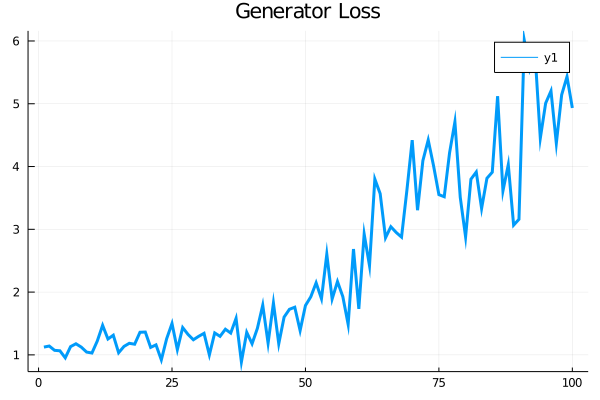

In [87]:
println("Generator loss")

# for l in gLoss_values
#     println(l)
# end

plot(gLoss_values, title = "Generator Loss", linewidth=3)

Discriminator loss


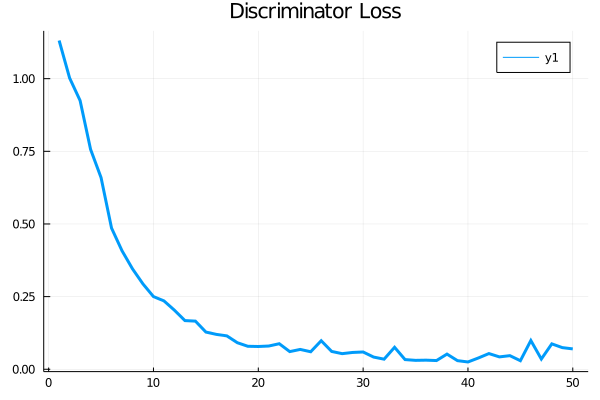

In [88]:
println("Discriminator loss")

# for l in dLoss_values
#     println(l)
# end

plot(dLoss_values, title = "Discriminator Loss", linewidth=3)

In [89]:
#Testing the Discriminator

d_fake = run_circuit(pprior())
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = run_d(data_train[index])
println("real data: $d_real") #Should print a number close to 1

fake data: 4.107388e-7
real data: 0.96892804


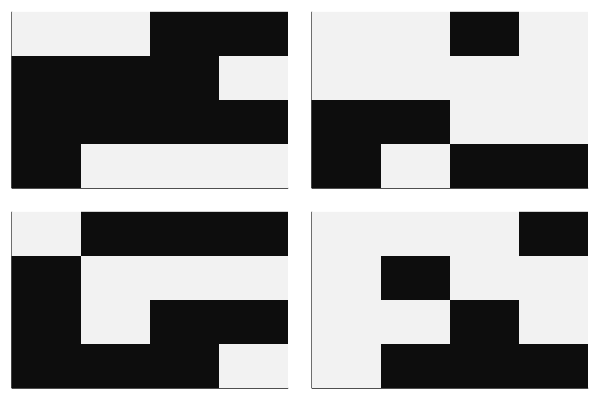

In [90]:
#Testing the Generator

nsamples = 4
samples = []
for i in 1:nsamples
    reg = fake_samples[i]
    s = reg |> g |> measure
    push!(samples, convertgd(s))
end
plot([heatmap(rotl90(reshape(s, compress_size, compress_size)), color=:grays, colorbar = false, ticks = false) for s in samples]...) #Not sure if the reshaping is correct but whatever